In [1]:
# Install library for reading JPK File
%pip uninstall jpkreader --yes
%pip install git+https://github.com/jlopezalo/pyjpkreader

Found existing installation: jpkreader 0.0.1
Uninstalling jpkreader-0.0.1:
  Successfully uninstalled jpkreader-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyjpkreader to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-t32raxj6
  Running command git clone -q https://github.com/jlopezalo/pyjpkreader /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-t32raxj6
  Created wheel for jpkreader: filename=jpkreader-0.0.1-py3-none-any.whl size=10194 sha256=f8745d2f3f06407a5f3dbbd8183104fdabeea165ed6e78c94dd5edbc5d316a59
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-pj7udj6i/wheels/23/c0/8e/c378f28c65b0199f6092b6aa45e090c1ed6b4093f3adb03a15
Successfully built jpkreader
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-z1166_s_
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-z1166_s_
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=23386 sha256=9fb10842f4434d491e7d7a48ec0d8a8e4184517406f300376d44553db9aa3d67
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-l6kedt0u/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np

# Get file reader from library
from jpkreader import load_jpk_file
import matplotlib.pyplot as plt

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.hertz_fit import HertzFit
from pyafmrheo.ting_fit import TingFit

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: Paraboloid, Pyramidal
indenter_shape = "pyramid"
# tip_parameter = 5000 * 1e-9 # meters
tip_parameter = 35 # degrees
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
contact_offset= 0

In [5]:
file = load_jpk_file(file_path)

In [6]:
file_id = file.file_id
file_type = file.file_type
file_metadata = file.file_metadata
file_data = file.data
piezo_image = file.piezo_image
quality_map = file.quality_map

In [7]:
closed_loop = file_metadata['z_closed_loop_status']
file_deflection_sensitivity = file_metadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = file_metadata['original_spring_constant'] #N/m
height_channel = file_metadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [8]:
curve_idx = 0
force_curve = file_data[curve_idx]
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = [*extend_segments, *pause_segments, *modulation_segments, *retract_segments]
force_curve_segments = sorted(force_curve_segments, key=lambda x: int(x[0]))

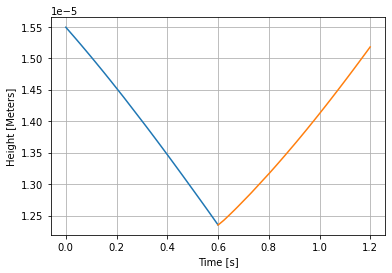

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

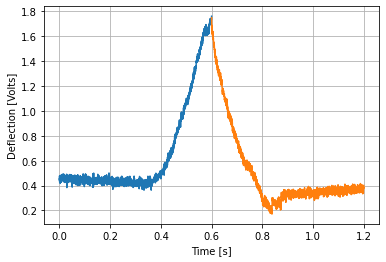

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

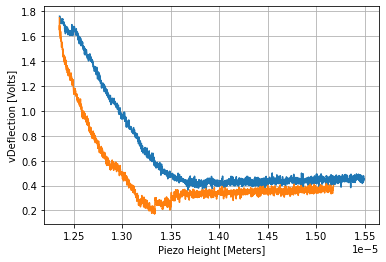

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
_, approach_segment = force_curve.extend_segments[0]
approach_segment_metadata = approach_segment.segment_metadata

app_deflection, app_height, app_time =\
    preprocess_segment(approach_segment, height_channel, deflection_sensitivity)

_, retract_segment = force_curve.retract_segments[-1]
retract_segment_metadata = retract_segment.segment_metadata
ret_deflection, ret_height, ret_time =\
    preprocess_segment(retract_segment, height_channel, deflection_sensitivity)

In [13]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height

In [14]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=100)
print(*poc)

1.2945790723301186e-06 8.822435844374262e-10


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


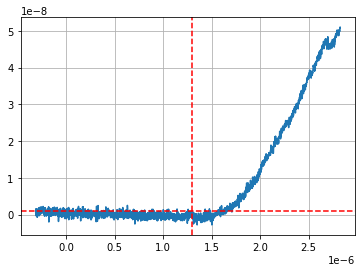

In [15]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

Hertz parameter names: ['delta0', 'E0', 'f0', 'slope']
Hertz independent variables: ['indentation']
[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 3000
    # variables        = 4
    chi-square         = 5.4774e-19
    reduced chi-square = 1.8282e-22
    Akaike info crit   = -150156.553
    Bayesian info crit = -150132.528
##  Warning: uncertainties could not be estimated:
[[Variables]]
    delta0: -2.4333e-12 (init = 0)
    f0:     -7.2661e-12 (init = 0)
    slope:  -9.4407e-06 (init = 1)
    E0:      384.409675 (init = 1000)


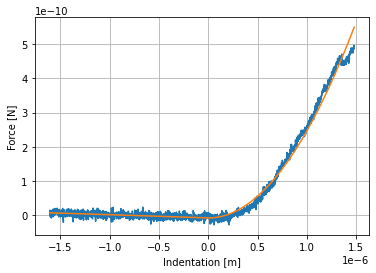

In [16]:
# Hertz fit
poc[1] = 0

app_indentation, app_force =\
    get_force_vs_indentation_curve(app_height, app_deflection, poc, spring_constant)
ret_indentation, ret_force =\
    get_force_vs_indentation_curve(ret_height, ret_deflection, poc, spring_constant)

# Initial parameters
# delta0, f0, slope, E0
p0 = [0, 0, 1, 1000]

hertz_result = HertzFit(app_indentation, app_force, indenter_shape, tip_parameter, p0, poisson_ratio)

hertz_E = hertz_result.best_values['E0']
hertz_d0 = hertz_result.best_values['delta0']

print(hertz_result.fit_report())

# Plot Hertz Fit results
plt.plot(app_indentation, app_force)
plt.plot(app_indentation, hertz_result.best_fit)
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.grid()
plt.show()

In [17]:
# Get force vs indentation for all segments
poc[0] += hertz_d0
poc[1] = 0

# Get indentation and force
app_indentation, app_force = get_force_vs_indentation_curve(app_height, app_deflection, poc, spring_constant)
ret_indentation, ret_force = get_force_vs_indentation_curve(ret_height, ret_deflection, poc, spring_constant)

In [18]:
indentation = np.r_[app_indentation, ret_indentation]
force = np.r_[app_force, ret_force]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]

In [22]:
fit_mask = indentation > (-1 * contact_offset)
    
ind_fit = indentation[fit_mask] 
force_fit = force[fit_mask]
time_fit = time[fit_mask]
time_fit = time_fit - time_fit[0]

# Parameters for fit
dT = time_fit[1] - time_fit[0]
dTp = 1
E0 = hertz_E
fluidity_exponent = 0.15
smoothing_window = 1
tmax = time_fit[ind_fit.argmax()]
v0t = (app_height[-1] - app_height[0]) / (app_time[-1] - app_time[0])
v0r = -1 * (ret_height[-1] - ret_height[0]) / (ret_time[-1] - ret_time[0])
print(v0t, v0r)
v0t = np.polyfit(app_time, app_indentation, 1)[0]
v0r = -1 * np.polyfit(ret_time, ret_indentation, 1)[0]
print(v0t, v0r)
slope = 0
tc = tmax/2
F0 = 0
d0 = 0
t0 = 1

5.234301175848542e-06 4.713657707101195e-06
5.1883863660564345e-06 4.710188017981836e-06


In [23]:
help(TingFit)

Help on function TingFit in module pyafmrheo.ting_fit:

TingFit(force, delta, time, model_probe, tip_parameter, p0, modelFt, poisson_ratio=0.5, vdrag=0, smooth_w=1, idx_tm=None)



In [25]:
p0_ting_num = [t0, E0, tc, fluidity_exponent, F0]

resultTingNum = TingFit(
    force_fit, ind_fit, time_fit, indenter_shape, tip_parameter, p0, 'numerical', poisson_ratio, 0, smoothing_window
)

print(resultTingNum.fit_report())

IndexError: list index out of range

In [26]:
p0_ting_anal = [t0, E0, tc, fluidity_exponent, F0]

resultTingAnal = TingFit(
     force_fit, ind_fit, time_fit, indenter_shape, tip_parameter, p0_ting_anal, 'numerical', poisson_ratio, 0, smoothing_window
)

print(resultTingAnal.fit_report())

IndexError: list index out of range

NameError: name 'resultTingNum' is not defined

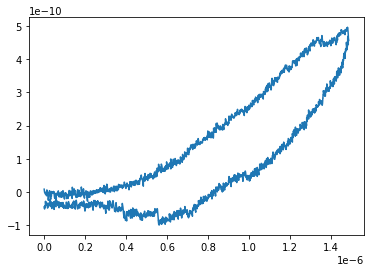

In [27]:
plt.plot(ind_fit, force_fit)
plt.plot(ind_fit, resultTingNum.best_fit, '--', label='Ting Numercial best fit')
plt.plot(ind_fit, resultTingAnal.best_fit, '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.abs(resultTingAnal.best_values['E0'] - resultTingNum.best_values['E0'])

In [ ]:
np.abs(resultTingAnal.best_values['beta'] - resultTingNum.best_values['alpha'])